# Analyze Sensing-Communication Trade-off

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

from cissir import visualization as viz
from cissir.utils import res_path
import numpy as np

viz.paper_style(line_cycler=False)

In [2]:
res_df = pd.DataFrame()
for f in res_path.rglob("*cb_results*.csv"):
    f_df = pd.read_csv(f, index_col=0)
    res_df = pd.concat([res_df, f_df])
if np.any(res_df.duplicated()):
    print("Warning, duplicated rows!")

In [3]:
print(f"Data columns: {*res_df.columns,}")
print(f"SI path type: {*res_df['si_taps'].unique(),}")
print(f"Opt methods : {*res_df['opt'].unique(),}")

Data columns: ('si_tgt', 'opt', 'rx_sdr_err', 'tx_sdr_err', 'si_opt', 'tx_loss', 'rx_loss', 'elapsed_time', 'si_sdr', 'tx_loss_sdr', 'rx_loss_sdr', 'si_full', 'phased', 'si_taps', 'num_beams', 'loss_tgt')
SI path type: (1, 'full')
Opt methods : ('cissir', 'lonestar')


In [4]:
tx_df = res_df.drop(columns="rx_loss")
tx_df["direction"] = "tx"
tx_df["cb_error"] = tx_df["tx_loss"]
rx_df = res_df.drop(columns="tx_loss")
rx_df["direction"] = "rx"
rx_df["cb_error"] = rx_df["rx_loss"]
bi_df = pd.concat([tx_df, rx_df]).reset_index()
bi_df.loc[:, "ant_array"] = bi_df.phased.map({True: "PH", False: "TAP"}) + "-" + bi_df.direction.str.upper()

In [5]:
x_span = 70
ymin, ymax = -40, -5

markevry = 6
marksize = 6
dashes = ((1,0), (1,0), (2,2), (2,2))

hue="opt"

si_label = r"Max. SI $\mathfrak{m}_{\mathbf F}(\mathbf{Z},\mathbf{Y})$ [dB]"
si1_label = r"Max. SI $\mathfrak{m}_{\mathbf{F}_1}(\mathbf{Z},\mathbf{Y})$ [dB]"
sig2tx = r"$\sigma^2_\mathrm{tx}$"
sig2rx = r"$\sigma^2_\mathrm{rx}$"
set_w = r"\mathcal{W}"
set_c = r"\mathcal{C}"
_ph = r"_{\oslash}"
_tap = r"_{\triangleright}"

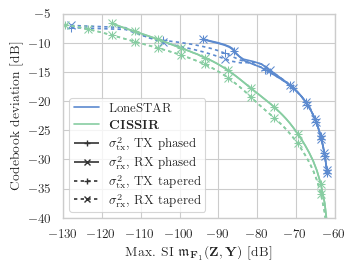

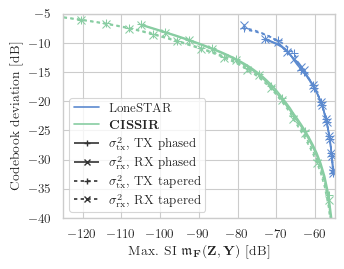

In [6]:
tex_labels = ["LoneSTAR",
              r"\textbf{CISSIR}",
              rf"{sig2tx}, TX phased", 
              rf"{sig2rx}, RX phased", 
              rf"{sig2tx}, TX tapered",
              rf"{sig2rx}, RX tapered"]


for xmax, xcol, xlabel, fname, df_query in [(-60, "si_opt", si1_label, "1tap_si",
                                             "si_taps == 1", ),
                                            (-55, "si_full", si_label, "full_si",
                                             "si_taps == 'full' or opt == 'lonestar'")]:
    xmin = xmax - x_span
    
    fig, ax = plt.subplots()
    sns.lineplot(bi_df.query(df_query), x=xcol, y="cb_error", style="ant_array", hue="opt", hue_order=['lonestar', 'cissir'],
                 style_order=["PH-TX", "PH-RX", "TAP-TX", "TAP-RX"], markers=["+", "x", "+", "x"],
                 dashes=dashes, markevery=markevry, markersize=marksize, markeredgecolor=None, ax=ax)
    handles, _ = ax.get_legend_handles_labels()
    
    ax.legend(handles[1:3] + handles[4:], tex_labels)
    
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel("Codebook deviation [dB]")
    
    viz.save(fig, fname)

In [7]:
list_cols = ["spec_nuc_tx", "spec_nuc_rx", "tx_degrees", "rx_degrees",
             "beam_dev_tx", "beam_dev_rx"]
df_list = []

for fname in res_path.rglob("*sdp*beam*full*.json"):
    with open(fname, 'r', encoding ='utf8') as json_file:
        beam_res = json.load(json_file)
    
    ach_si = beam_res.pop("ach_si")
    tx_deg = beam_res.pop("tx")
    rx_deg = beam_res.pop("rx")
    
    beam_df = pd.DataFrame(beam_res)
    beam_df = beam_df.assign(ach_si=np.max(ach_si, axis=-1), 
                             tx_degrees=[tx_deg["degrees"]] * len(beam_df),
                             rx_degrees=[rx_deg["degrees"]] * len(beam_df)).explode(list_cols)
    df_list.extend([beam_df.assign(side=sd, beam_degs=beam_df[f"{sd}_degrees"],
                                   spec_nuc=beam_df[f"spec_nuc_{sd}"], beam_dev=beam_df[f"beam_dev_{sd}"]).drop(columns=list_cols)
                    for sd in ("tx", "rx")])

beam_df = pd.concat(df_list).dropna()

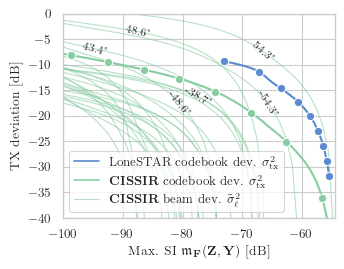

In [8]:
xmin, xmax = -100, -54.5

compare_plot = bi_df.query("(si_taps == 'full' or opt == 'lonestar') and direction == 'tx' and phased == True").reset_index()

beam_plot = beam_df.query("opt == 'sdr' and taps == 'full' and side == 'tx'").sort_values(by="ach_si", ascending=False).groupby("beam_degs")

f, ax = plt.subplots()

annotate = {26: -67, 25: -88, 0: -66, 24: -95, 1: -81.0, 3: -77}
for i, (b_deg, beam_curve) in enumerate(beam_plot):
    
    x_si = beam_curve.ach_si
    y_dev = beam_curve.beam_dev
    ax.plot(x_si, y_dev, c=viz.g, linewidth=0.8, alpha=0.6, label="b")

    if i in annotate.keys():
        viz.inline_annotation(x_si, y_dev, f"{b_deg:.1f}°", x_label=annotate[i],
                              background_alpha=0.0, axis=ax, fontsize=8)
    
ax = sns.lineplot(compare_plot, x="si_full", y="cb_error",hue=hue, hue_order=['lonestar', 'cissir'], linewidth=1.5,
                  marker="o",  markevery=markevry, markersize=6, ax=ax)

handles, labels = ax.get_legend_handles_labels()
labels = [lb.replace("TX", sig2tx).replace("RX", sig2rx) for lb in labels]
ax.legend(handles[-2:] + handles[1:2], ["LoneSTAR codebook dev. " + sig2tx,
                                        r"\textbf{CISSIR} codebook dev. " + sig2tx,
                                        r"\textbf{CISSIR} beam dev. $\tilde{\sigma}_{\ell}^2$"], loc="lower left")

plt.xlim(xmin, xmax)
plt.ylim(ymin, 0)

_ = plt.xlabel(si_label)
_ = plt.ylabel("TX deviation [dB]")

viz.save(f, "full_si_beam", format="pdf")